In [34]:
###############################################################
# TIME SERIES FORECASTING ON TRANSACTION COUNTS
###############################################################

# Iyzico financial technology company providing solutions for online transactions.
# Providing payment infrastructure for e-commerce, marketplace company's and individual users.
# This project is to forecast sum of the trade volumes based on merchant_id on daily basis for last 3 months of the year 2020.


In [35]:
###############################################################
# DATA SET
###############################################################
#  Data set consist of transactions of 7 member merchants from 2018 to 2020

# Transaction:Transaction counts
# MerchantID :
# Paid Price :


In [36]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')


In [37]:
###############################################################
# TASK 1 : Exploratory Data Analysis (EDA)
###############################################################

# 1.Read the data ande convert dtype to date.
df = pd.read_csv("iyzico_data.csv")
df.drop("Unnamed: 0", axis=1,inplace=True)

df["transaction_date"].dtypes
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df.tail()
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [38]:
# 2.Let's check min max dates and length
df["transaction_date"].min() # Timestamp('2018-01-01 00:00:00')
df["transaction_date"].max() # Timestamp('2020-12-31 00:00:00')

Timestamp('2020-12-31 00:00:00')

In [39]:
len(df["transaction_date"])

7667

In [40]:
# # See the nr of merchans
(df["merchant_id"].unique())

array([   535,  42616,  46774,  86302, 124381, 129316,  57192],
      dtype=int64)

In [41]:
# 4.total nr payment grouped by merchants ?
df.groupby("merchant_id").agg({"Total_Paid":"sum"})

,Total_Paid
merchant_id,
535,156601530.234
42616,354583091.808
46774,1567200341.286
57192,317337137.586
86302,2870446.716
124381,1158692543.973
129316,1555471.476


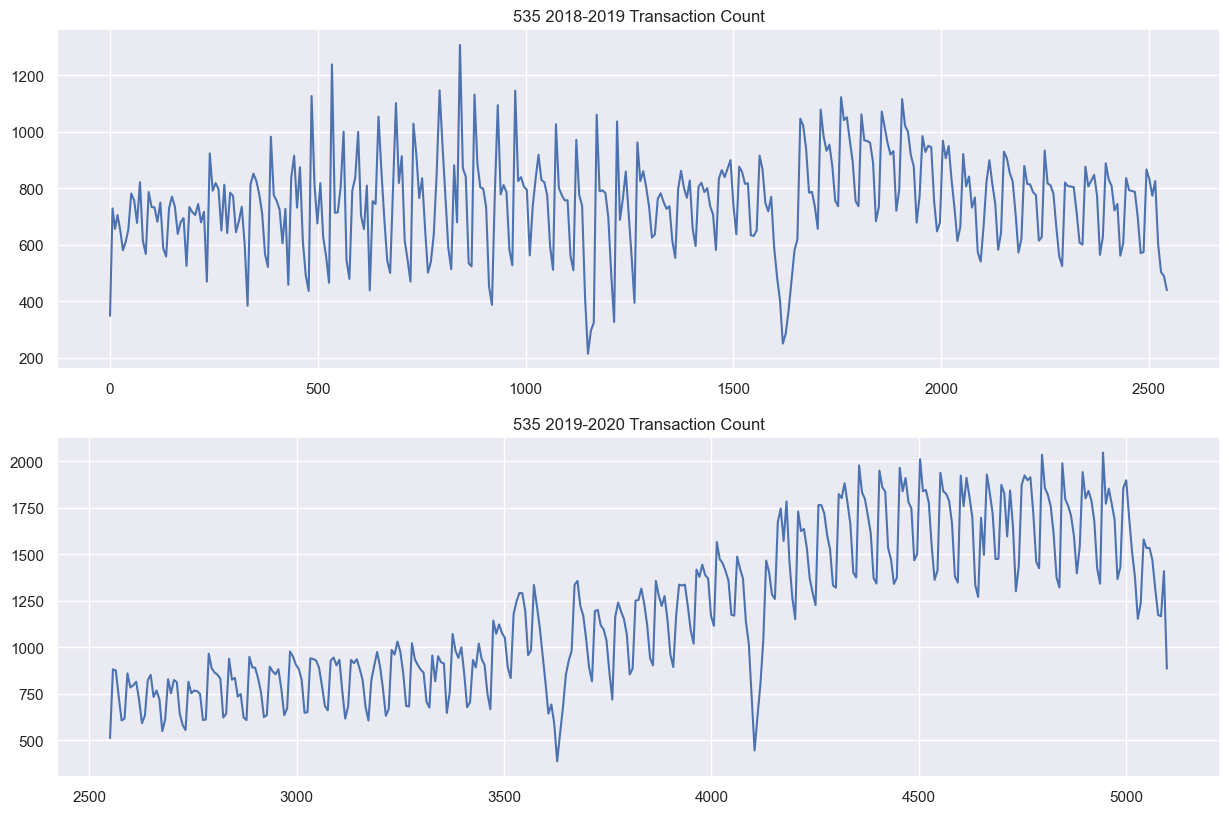

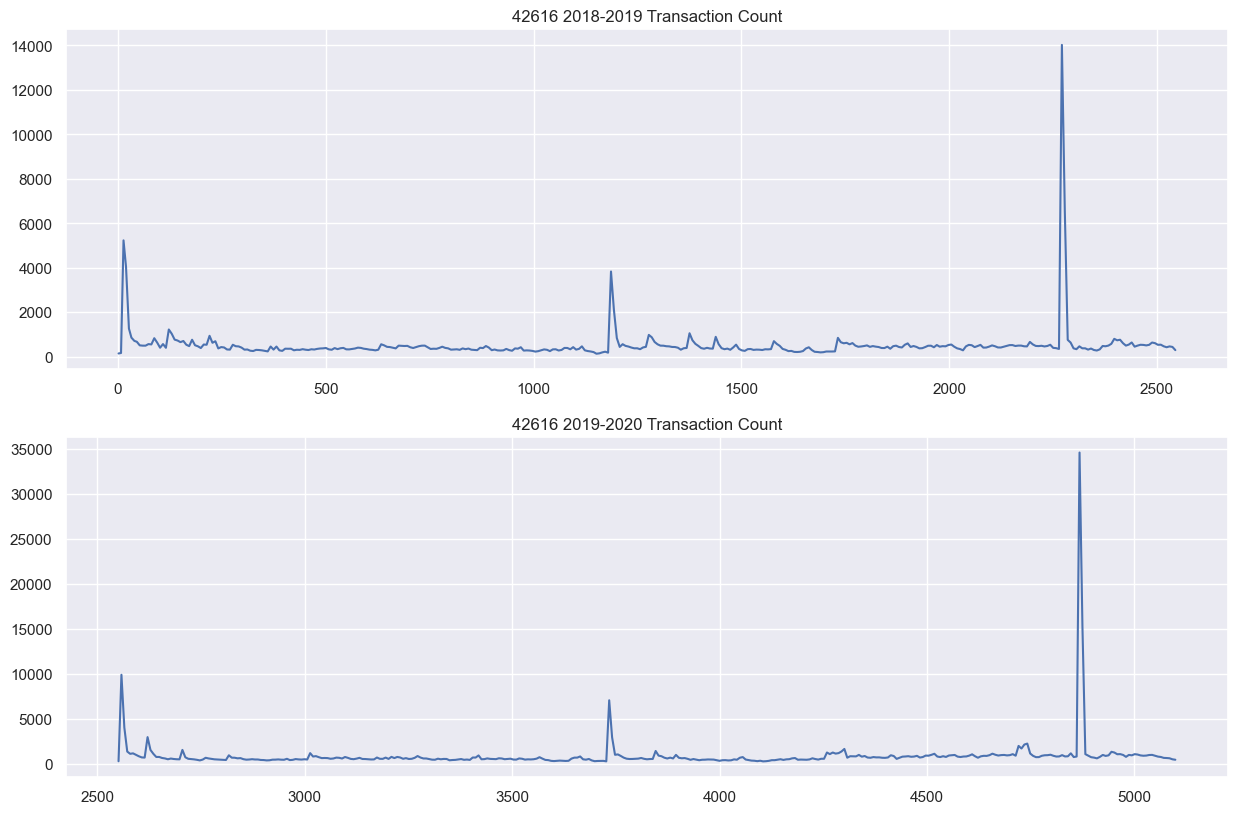

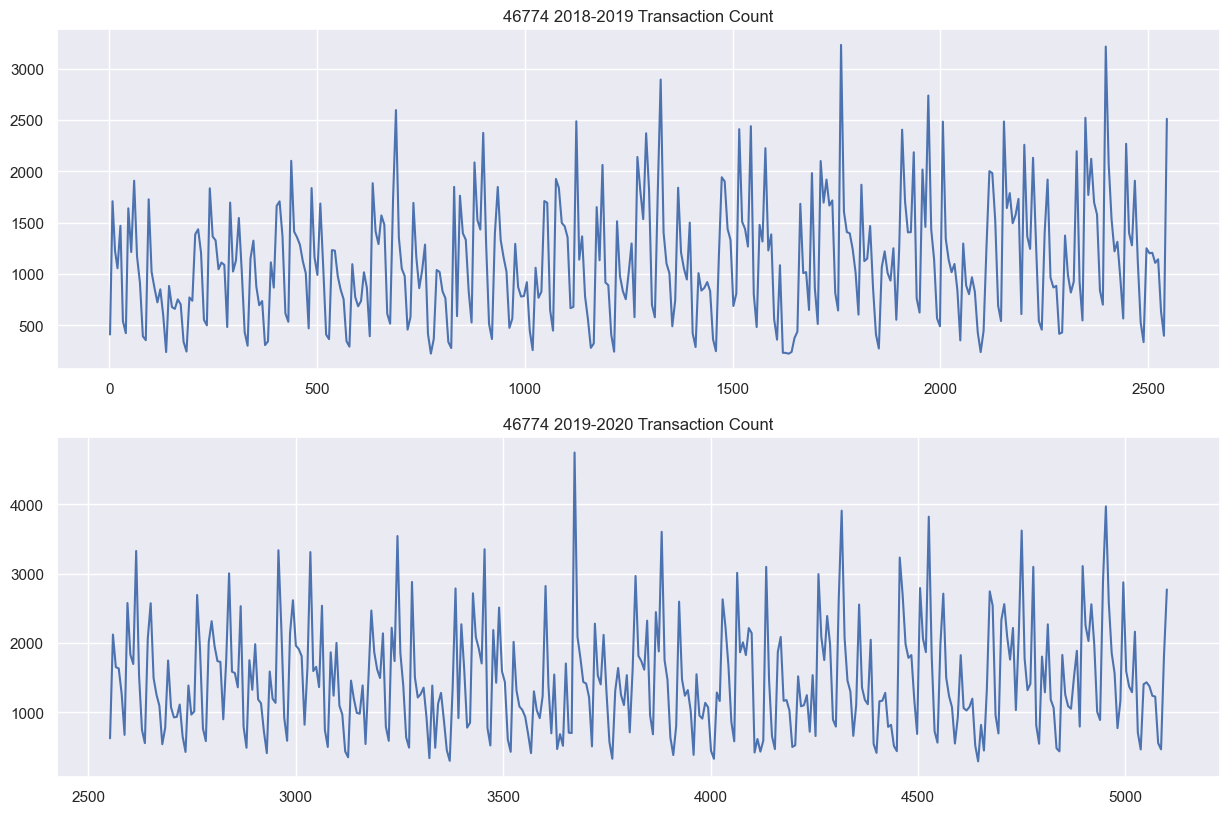

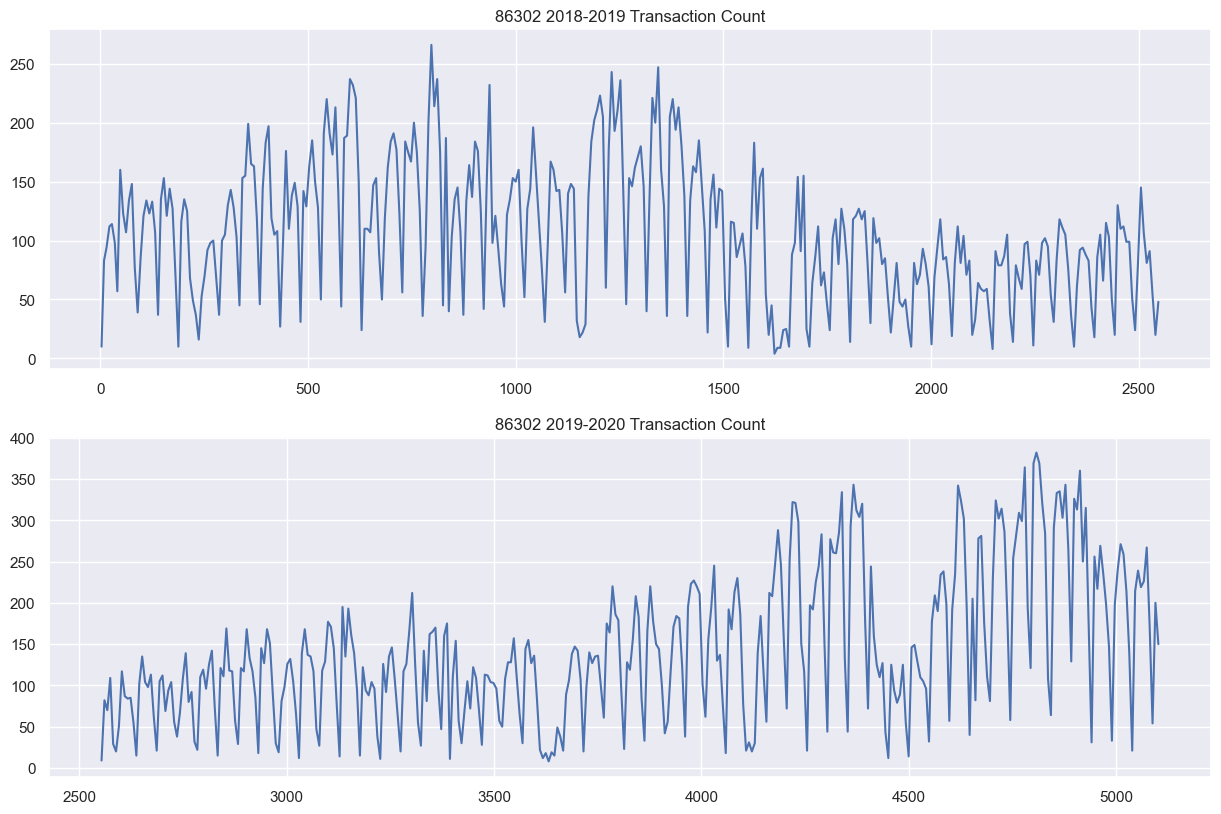

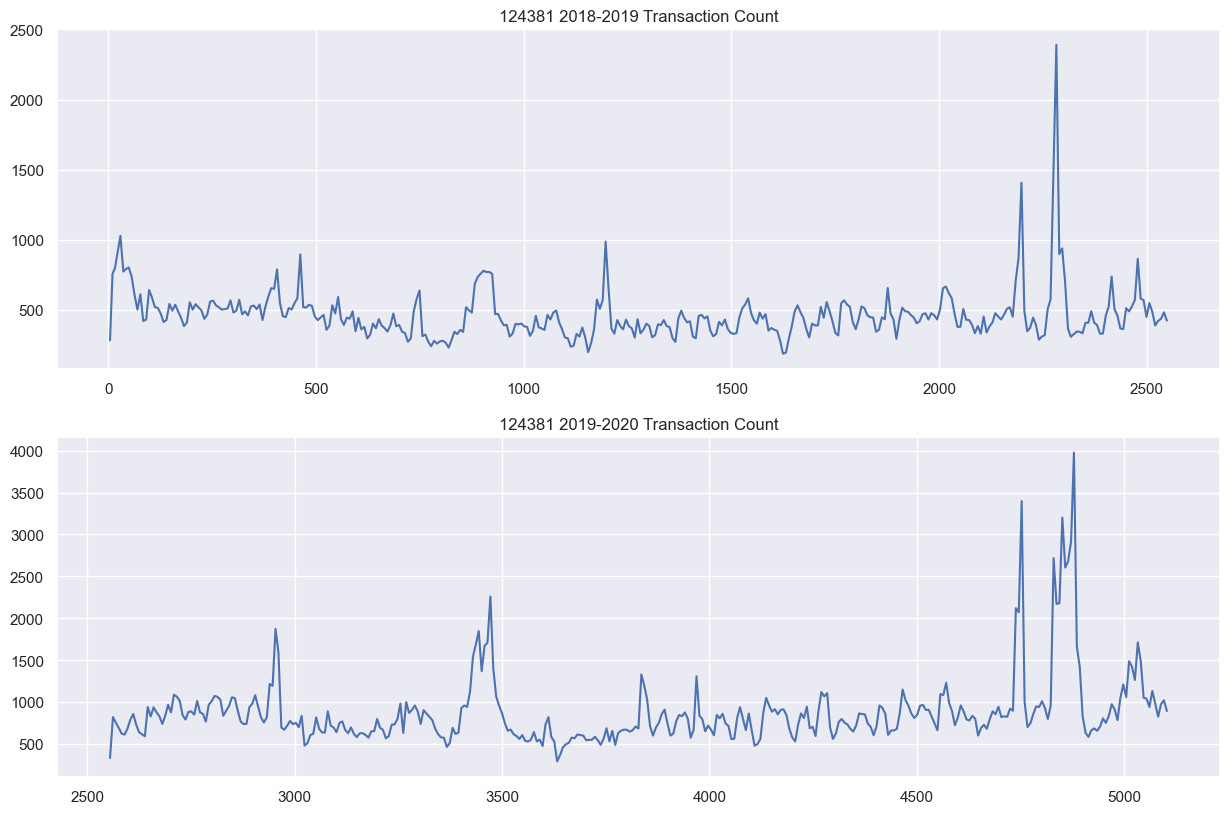

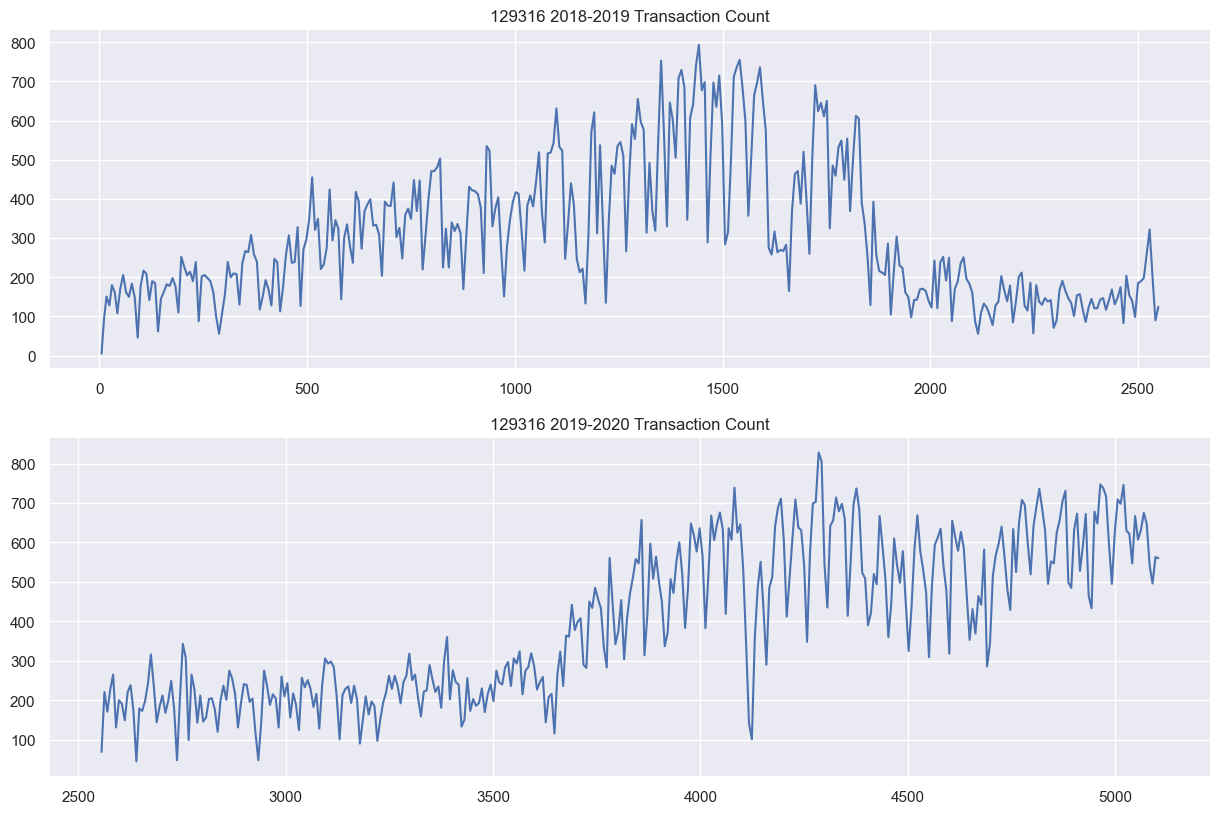

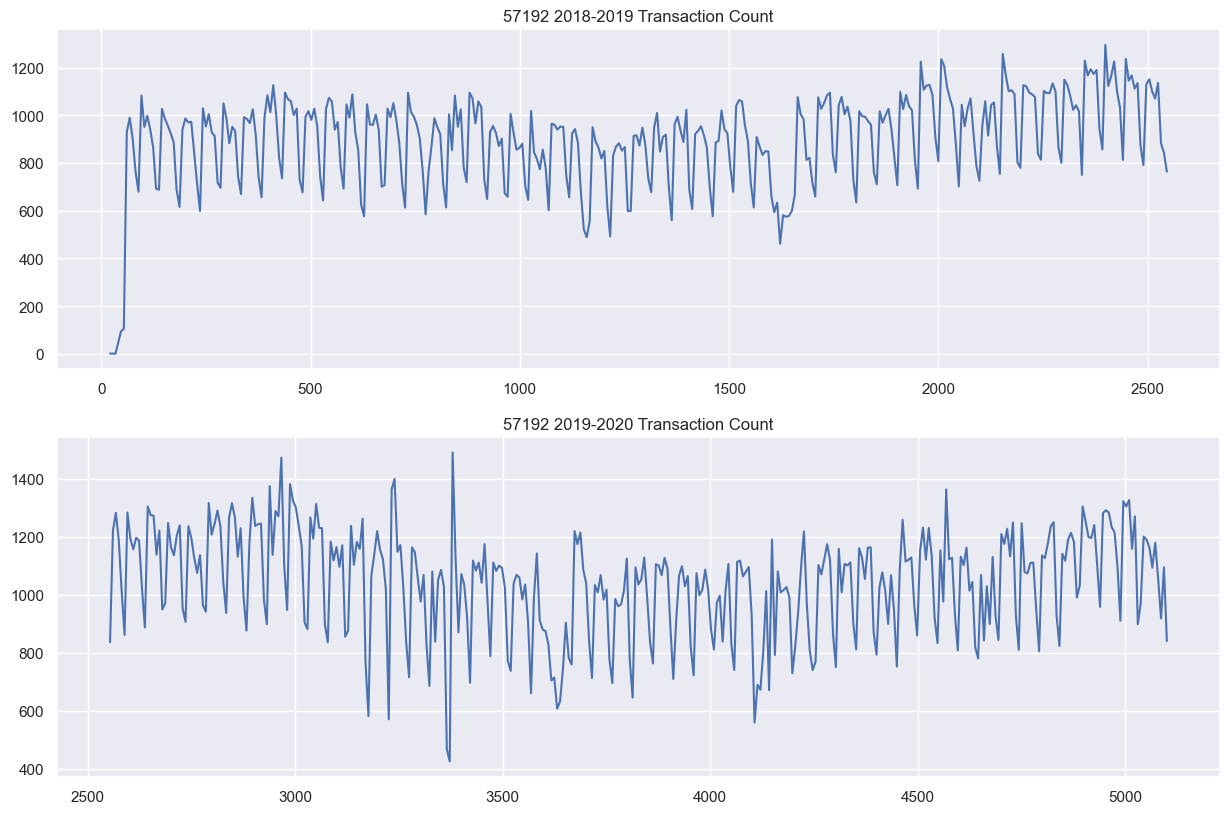

In [42]:
# 5. draw transaction count graphic for each merchant
for id in df.merchant_id.unique():
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, 1, title = str(id) + ' 2018-2019 Transaction Count')
    df[(df.merchant_id == id) & ( df.transaction_date >= "2018-01-01" ) & (df.transaction_date < "2019-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.subplot(3, 1, 2,title = str(id) + ' 2019-2020 Transaction Count')
    df[(df.merchant_id == id) &( df.transaction_date >= "2019-01-01" )& (df.transaction_date < "2020-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.show()

In [43]:
###############################################################
# TASK 2 : FEATURE ENGINEERING WITH TIME SERIES DATA
###############################################################

########################
# Date Features
########################

def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

In [44]:
df = create_date_features(df, "transaction_date")
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [45]:
# Total nr. of transactions on daily,monthly and yearly basis for each merchant
df.groupby(["merchant_id","year","month","day_of_month"]).agg({"Total_Transaction": ["sum", "mean", "median"]})

Total_Transaction                    
                                                  sum      mean    median
merchant_id year month day_of_month                                      
535         2018 1     1                          349   349.000   349.000
                       2                          729   729.000   729.000
                       3                          657   657.000   657.000
                       4                          706   706.000   706.000
                       5                          648   648.000   648.000
                       6                          581   581.000   581.000
                       7                          613   613.000   613.000
                       8                          654   654.000   654.000
                       9                          782   782.000   782.000
                       10                         758   758.000   758.000
                       11                         678   678.000   678.000
                       12                         822   822.000   822.000
                       13                         615   615.000   615.000
                       14                         568   568.000   568.000
                       15                         787   787.000   787.000
                       16                         734   734.000   734.000
                       17                         733   733.000   733.000
                       18                         682   682.000   682.000
                       19                         750   750.000   750.000
                       20                         588   588.000   588.000
                       21                         559   559.000   559.000
                       22                         730   730.000   730.000
                       23                         771   771.000   771.000
                       24                         736   736.000   736.000
                       25                         639   639.000   639.000
                       26                         681   681.000   681.000
                       27                         695   695.000   695.000
                       28                         526   526.000   526.000
                       29                         734   734.000   734.000
                       30                         716   716.000   716.000
                       31                         706   706.000   706.000
                 2     1                          745   745.000   745.000
                       2                          680   680.000   680.000
                       3                          717   717.000   717.000
                       4                          470   470.000   470.000
                       5                          924   924.000   924.000
                       6                          792   792.000   792.000
                       7                          819   819.000   819.000
                       8                          798   798.000   798.000
                       9                          651   651.000   651.000
                       10                         813   813.000   813.000
                       11                         642   642.000   642.000
                       12                         785   785.000   785.000
                       13                         773   773.000   773.000
                       14                         645   645.000   645.000
                       15                         684   684.000   684.000
                       16                         735   735.000   735.000
                       17                         601   601.000   601.000
                       18                         385   385.000   385.000
                       19                         814   814.000   814.000
                       20                         852   852.000   852.000
                       21               

In [52]:
# Total nr. of payments on monthly and yearly basis for each merchant
df.groupby(["merchant_id","year","month"]).agg({"Total_Paid": ["sum", "mean", "median"]}).head(10)


Total_Paid                      
                               sum       mean     median
merchant_id year month                                  
535         2018 1     2091231.810  67459.091  71088.660
                 2     2060521.056  73590.038  73345.545
                 3     2371568.274  76502.202  71045.640
                 4     2504558.754  83485.292  83215.548
                 5     2831761.170  91347.135  90838.422
                 6     2433137.958  81104.599  84910.374
                 7     2741248.350  88427.366  89439.408
                 8     2724770.016  87895.807  91272.600
                 9     3130433.640 104347.788 105952.887
                 10    3187022.904 102807.190 106419.402

In [14]:
########################
# Lag/Shifted Features
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

In [20]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
########################
# Rolling Mean Features
########################

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
######################################
# Exponentially Weighted Mean Features
######################################

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)
df.tail()


,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

In [23]:
########################
# Black Friday - Summer Solstice
########################

df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_black_friday"]=1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin(["2018-06-19","2018-06-20","2018-06-21","2018-06-22",
                                    "2019-06-19","2019-06-20","2019-06-21","2019-06-22",]) ,"is_summer_solstice"]=1

In [24]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

In [25]:
########################
# One-Hot Encoding
########################
df.head()

df = pd.get_dummies(df, columns=['merchant_id','day_of_week', 'month'])
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)

In [26]:
########################
# Custom Cost Function
########################

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


In [27]:
############################
# Time-Based Validation Sets
############################

import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# 2020'nin 10.ayına kadar train seti.
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]

# 2020'nin son 3 ayı validasyon seti.
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

cols = [col for col in train.columns if col not in ['transaction_date', 'id', "Total_Transaction","Total_Paid", "year" ]]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 212), (644,), (644, 212))

In [28]:
########################
# TASK 3: MODELLING
########################
# LightGBM Model
########################

# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012306 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.297499	training's SMAPE: 28.5139	valid_1's l1: 0.281232	valid_1's SMAPE: 26.8447
[200]	training's l1: 0.242813	training's SMAPE: 23.4916	valid_1's l1: 0.228073	valid_1's SMAPE: 21.9854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l1: 0.22169	training's SMAPE: 21.5322	valid_1's l1: 0.217497	valid_1's SMAPE: 21.062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

20.99276658058069

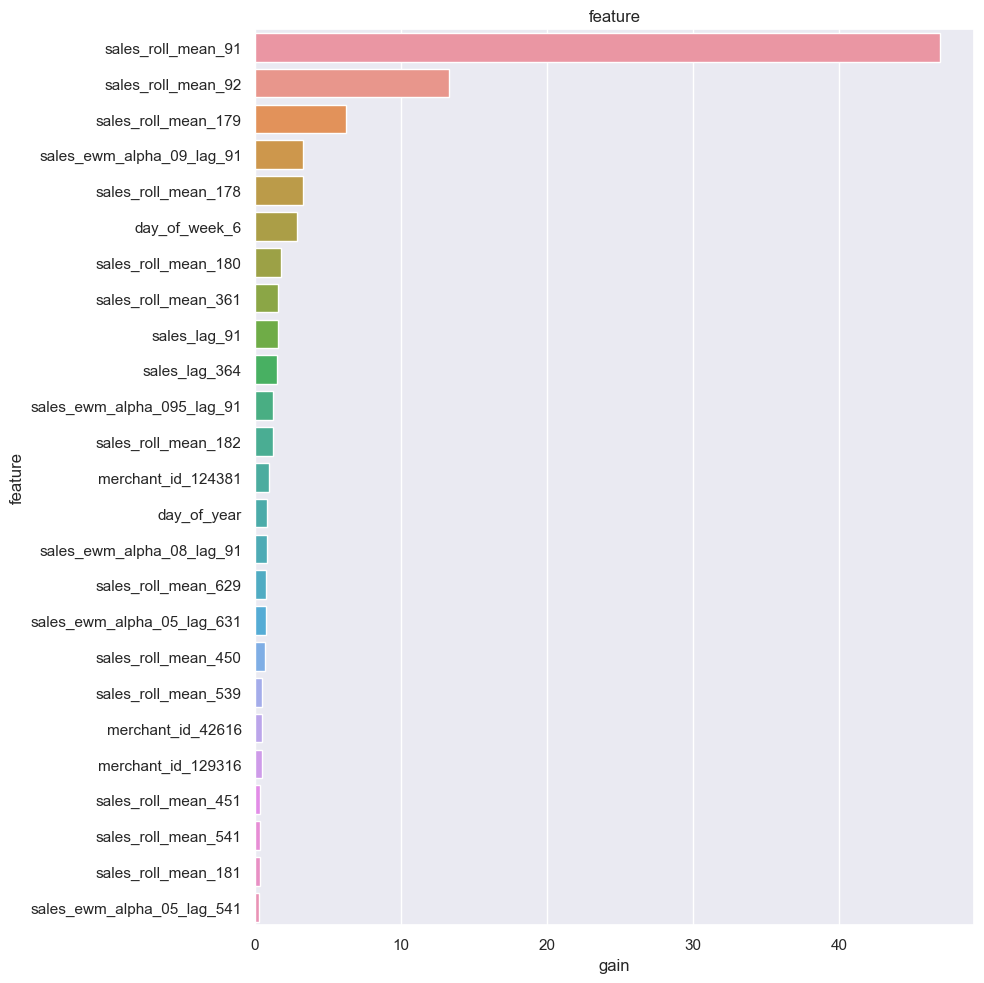

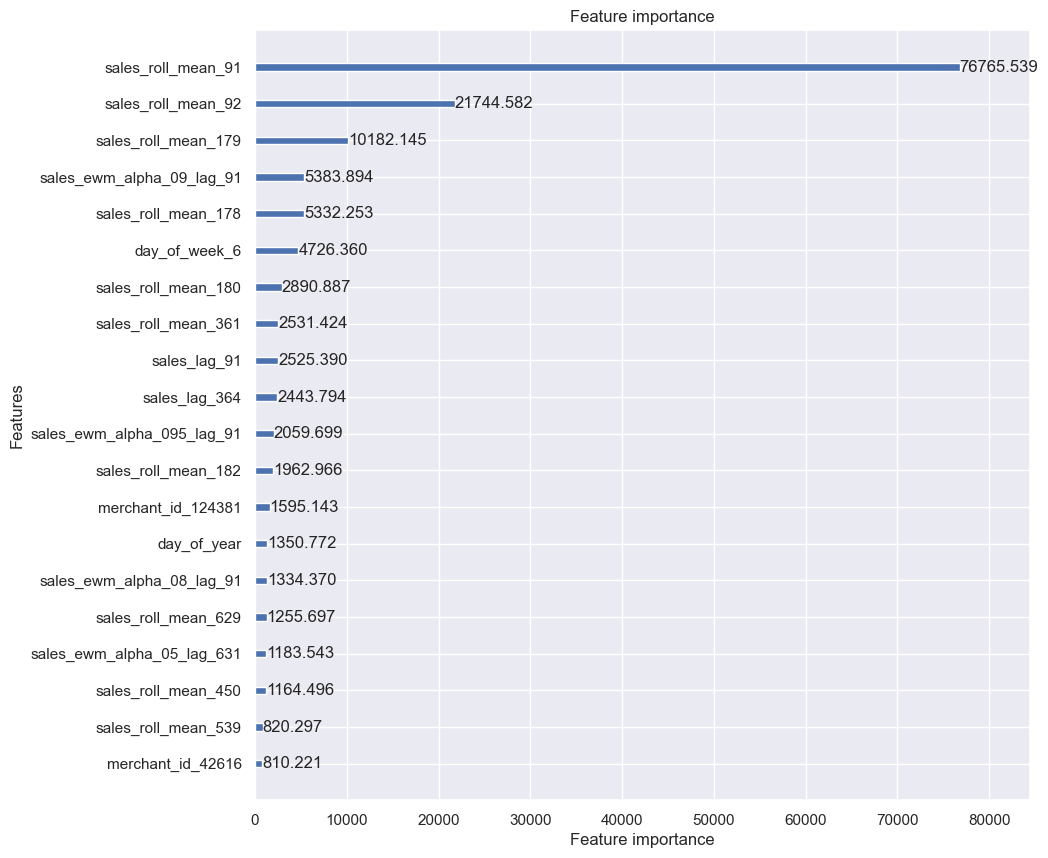

In [29]:
########################
# FEATURE IMPORTANCE
########################

def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()
